# Dengue Alerta

In [1]:
from matplotlib import pyplot as plt
from eralchemy import render_er
from IPython.display import display 
from PIL import Image
from datetime import datetime, date, timedelta

import os
import matplotlib as mpl
import numpy as np
import pandas as pd
import psycopg2
import pytz
import sys
import sqlalchemy as sqla

In [2]:
dir_root = os.path.dirname(os.getcwd())
dir_app = os.path.join(
    dir_root, 'AlertaDengue'
)

sys.path.insert(0, dir_app)
from AlertaDengue import settings
from dados import dbdata

## Database

In [3]:
# connection
db_dsn = 'postgresql://{}:{}@{}/{}'.format(
    settings.PSQL_USER,
    settings.PSQL_PASSWORD,
    settings.PSQL_HOST,
    settings.PSQL_DB)
engine = sqla.create_engine(db_dsn)

In [4]:
# scheme
pd.read_sql('SELECT nspname FROM pg_catalog.pg_namespace;', engine)

# Dengue_global
# Municipio

,nspname
0,pg_toast
1,pg_temp_1
2,pg_toast_temp_1
3,pg_catalog
4,information_schema
5,Dengue_global
6,Municipio
7,public


,table_name
0,CID10
1,estado
2,Municipio
3,regional_saude


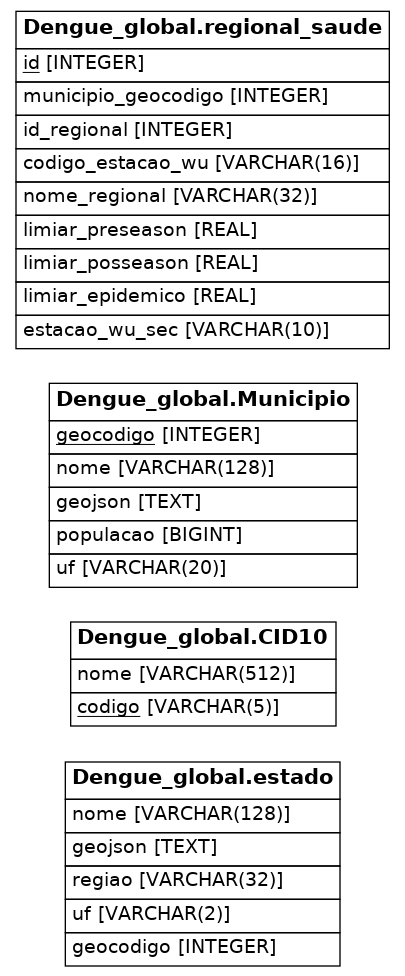

In [5]:
# Schema: Dengue_global

sql = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema='Dengue_global'
ORDER BY table_schema,table_name;
'''

display(pd.read_sql(sql, engine))

render_er(db_dsn, '/tmp/img.png', schema='Dengue_global')
Image.open('/tmp/img.png')

In [6]:
sql = 'SELECT * from "Dengue_global"."Municipio"'
pd.read_sql(sql, engine).head()

,geocodigo,nome,geojson,populacao,uf
0,2204303,Fronteiras,"{""id"": null, ""geometry"": {""coordinates"": [[[-4...",11411,Piauí
1,2501807,Bayeux,"{""id"": null, ""geometry"": {""coordinates"": [[[-3...",95677,Paraíba
2,2905008,Caculé,"{""id"": null, ""geometry"": {""coordinates"": [[[-4...",23392,Bahia
3,3105608,Barbacena,"{""id"": null, ""geometry"": {""coordinates"": [[[-4...",133972,Minas Gerais
4,1100015,Alta Floresta D'Oeste,"{""id"": null, ""geometry"": {""coordinates"": [[[-6...",25652,Rondônia


,table_name
0,alerta_mrj
1,Bairro
2,Clima_cemaden
3,Clima_Satelite
4,Clima_wu
5,Estacao_cemaden
6,Estacao_wu
7,Historico_alerta
8,Localidade
9,Notificacao


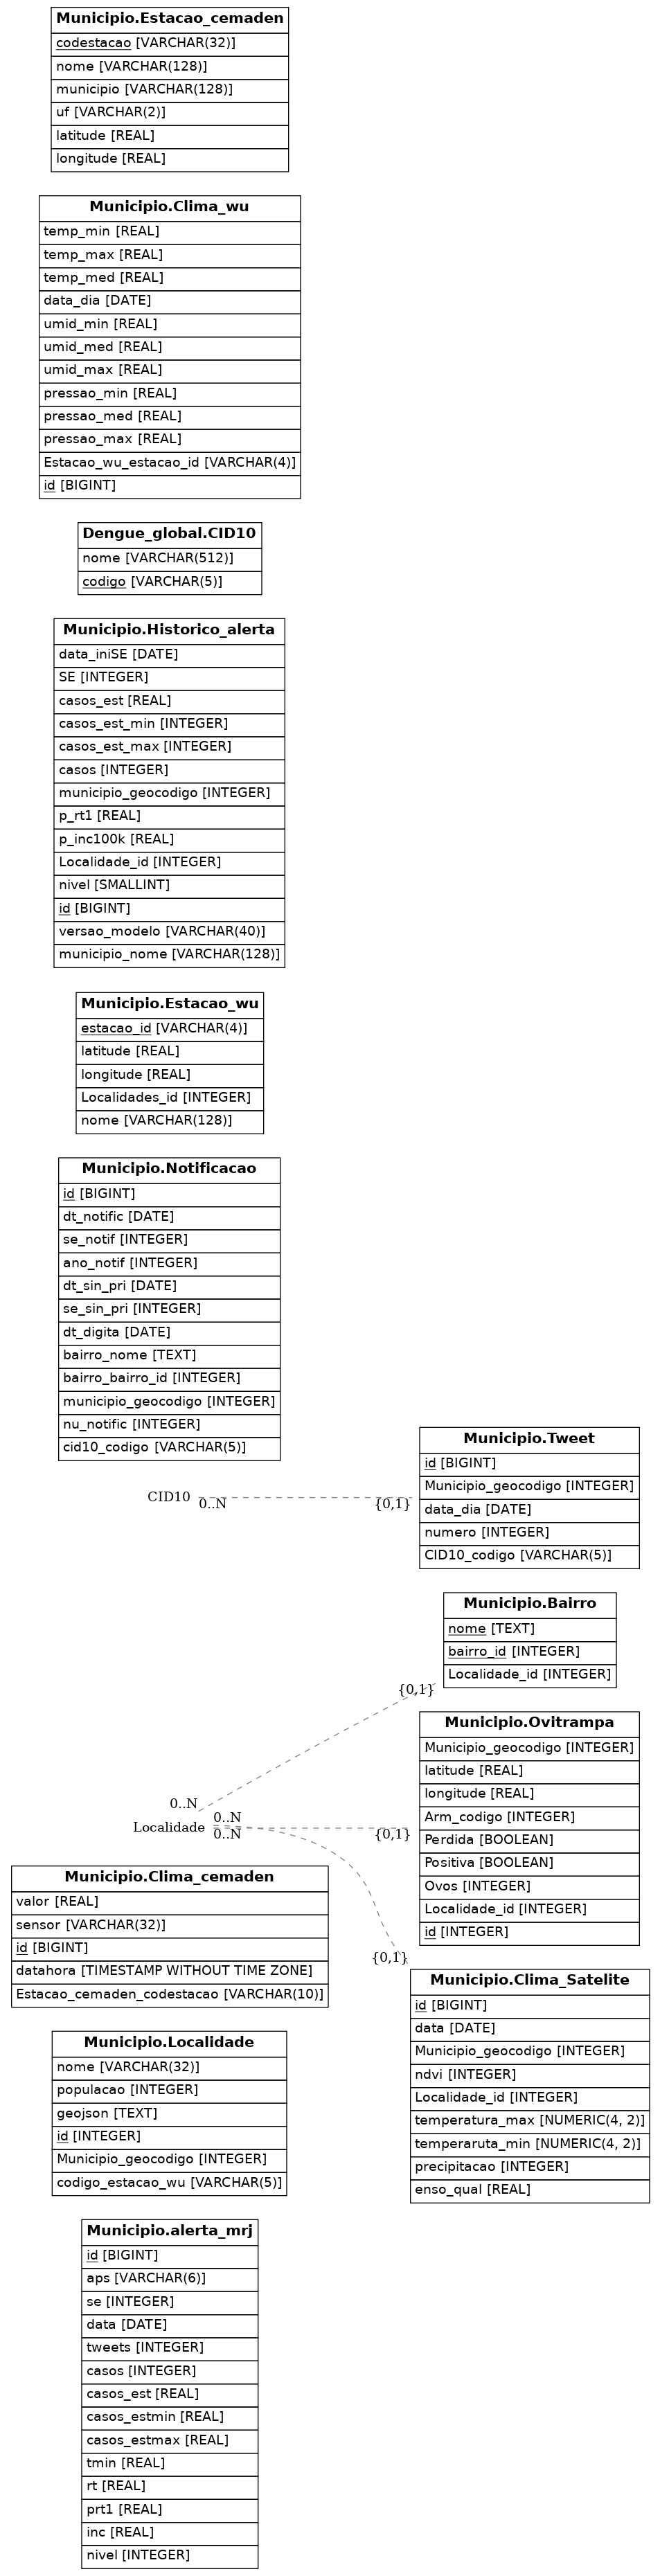

In [7]:
# Schema: Municipio

sql = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema='Municipio'
ORDER BY table_schema,table_name;
'''

display(pd.read_sql(sql, engine))

render_er(db_dsn, '/tmp/img.png', schema='Municipio')
Image.open('/tmp/img.png')

In [8]:
sql = 'SELECT * from "Municipio"."Historico_alerta"'
pd.read_sql(sql, engine).head()

,data_iniSE,SE,casos_est,casos_est_min,casos_est_max,casos,municipio_geocodigo,p_rt1,p_inc100k,Localidade_id,nivel,id,versao_modelo,municipio_nome
0,2016-09-11,201637,0.0,0,0,0,4103057,0.000000,0.0000,0,1,4103057020163717144,2016-12-09,None
1,2015-01-11,201502,0.0,0,0,0,3305604,0.000000,0.0000,0,1,3305604020150217149,2016-12-14,Silva Jardim
2,2011-05-08,201119,392.0,392,392,392,3300100,0.997485,211.9610,0,4,3300100020111917149,2016-12-14,Angra dos Reis
3,2011-06-05,201123,185.0,185,185,185,3300100,0.000006,100.0320,0,4,3300100020112317149,2016-12-14,Angra dos Reis
4,2011-12-18,201151,27.0,27,27,27,3300100,0.966214,14.5993,0,1,3300100020115117149,2016-12-14,Angra dos Reis


## Essay #1

* Municípios participantes
* Total de casos notificado e estimados na semana
* Previsão de casos para as próximas semanas
* Variação em relação à semana anterior

In [9]:
ufs = ['Rio de Janeiro', 'Paraná', 'Espírito Santo']
ufs_s = ["'%s'" % v for v in ufs]

In [10]:
# Municípios participantes

sql = '''
SELECT uf, COALESCE(COUNT(municipio_geocodigo), 0) AS count
FROM (
    SELECT DISTINCT municipio_geocodigo 
    FROM "Municipio"."Historico_alerta") AS alerta
INNER JOIN "Dengue_global"."Municipio" AS municipio
  ON alerta.municipio_geocodigo = municipio.geocodigo
WHERE uf IN (%s)
GROUP BY uf
''' % ','.join(ufs_s)

display(pd.read_sql(sql, engine))

,uf,count
0,Espírito Santo,78
1,Paraná,399
2,Rio de Janeiro,92


In [11]:
# Total de casos notificado e estimados na semana
for w in ['36', '37']:

    se = str(datetime.now().isocalendar()[0])
    # se += str(datetime.now().isocalendar()[1]).rjust(2, '0')
    se += w

    sql = '''
    SELECT 
        uf, 
        COALESCE(SUM(casos), 0) AS casos, 
        COALESCE(SUM(casos_est), 0) AS casos_est
    FROM "Municipio"."Historico_alerta" AS alerta
    INNER JOIN "Dengue_global"."Municipio" AS municipio
      ON alerta.municipio_geocodigo = municipio.geocodigo
    WHERE uf IN (%s) AND "SE" = %s
    GROUP BY uf
    ''' % (','.join(ufs_s), se)

    display(pd.read_sql(sql, engine))

,uf,casos,casos_est


,uf,casos,casos_est


In [12]:
# Previsão de casos para as próximas semanas
# TODO: atualmente está igual à semana atual
for w in ['36', '37']:
    for uf in ufs:
        se = str(datetime.now().isocalendar()[0])
        # se += str(datetime.now().isocalendar()[1]).rjust(2, '0')
        se += w

        sql = '''
        SELECT SUM(casos) AS casos, SUM(casos_est) AS casos_est
        FROM "Municipio"."Historico_alerta" AS alerta
        INNER JOIN "Dengue_global"."Municipio" AS municipio
          ON alerta.municipio_geocodigo = municipio.geocodigo
        WHERE uf='%s' AND "SE" = %s
        ''' % (uf, se)
        
        print('\n', uf, se)
        display(pd.read_sql(sql, engine))


 Rio de Janeiro 201736


,casos,casos_est
0,None,None



 Paraná 201736


,casos,casos_est
0,None,None



 Espírito Santo 201736


,casos,casos_est
0,None,None



 Rio de Janeiro 201737


,casos,casos_est
0,None,None



 Paraná 201737


,casos,casos_est
0,None,None



 Espírito Santo 201737


,casos,casos_est
0,None,None


In [13]:
# Variação em relação à semana anterior

se1 = str(datetime.now().isocalendar()[0])
# se += str(datetime.now().isocalendar()[1]).rjust(2, '0')
se1 += '36'

se2 = str(datetime.now().isocalendar()[0])
# se += str(datetime.now().isocalendar()[1]).rjust(2, '0')
se2 += '37'

sql = '''
SELECT 
    uf,
    (SUM(alerta.casos)-SUM(alerta_passado.casos)) AS casos, 
    (SUM(alerta.casos_est)-SUM(alerta_passado.casos_est)) AS casos_est
FROM "Municipio"."Historico_alerta" AS alerta
INNER JOIN "Municipio"."Historico_alerta" AS alerta_passado
  ON (
    alerta.municipio_geocodigo = alerta_passado.municipio_geocodigo
    AND alerta."SE"=%s
    AND alerta_passado."SE"=%s)
INNER JOIN "Dengue_global"."Municipio" AS municipio
  ON alerta.municipio_geocodigo = municipio.geocodigo
WHERE uf IN (%s)
GROUP BY uf
''' % (se2, se1, ','.join(ufs_s))

display(pd.read_sql(sql, engine))

,uf,casos,casos_est


## Dashboard Dengue

In [14]:
# Distribuição por tipo de doença
uf = 'Paraná'

sql = '''
SELECT *
FROM "Municipio"."Notificacao" AS alerta
INNER JOIN "Dengue_global"."Municipio" AS municipio
  ON alerta.municipio_geocodigo = municipio.geocodigo
INNER JOIN "Dengue_global"."CID10" AS cid10
  ON alerta.cid10_codigo = cid10.codigo
WHERE uf='{}' AND se_notif=36 AND ano_notif=2016
LIMIT 2
'''.format(uf)

display(pd.read_sql(sql, engine))

,id,dt_notific,se_notif,ano_notif,dt_sin_pri,se_sin_pri,dt_digita,bairro_nome,bairro_bairro_id,municipio_geocodigo,nu_notific,cid10_codigo,geocodigo,nome,geojson,populacao,uf,nome,codigo
0,8716731,2016-09-10,36,2016,2016-09-05,36,2016-09-15,AQUILES STENGHEL UBS,2577852,4113700,4132505,A90,4113700,Londrina,"{""id"": null, ""geometry"": {""coordinates"": [[[-5...",543003,Paraná,Dengue [dengue clássico],A90
1,9566042,2016-09-10,36,2016,1970-06-22,25,2016-10-03,FARROPILHA,7482,4118402,3119181,A90,4118402,Paranavaí,"{""id"": null, ""geometry"": {""coordinates"": [[[-5...",86218,Paraná,Dengue [dengue clássico],A90


In [15]:
# Distribuição por gênero
uf = 'Paraná'

sql = '''
SELECT *
FROM "Municipio"."Historico_alerta" AS alerta
INNER JOIN "Dengue_global"."Municipio" AS municipio
  ON alerta.municipio_geocodigo = municipio.geocodigo
LIMIT 2
'''

display(pd.read_sql(sql, engine))

,data_iniSE,SE,casos_est,casos_est_min,casos_est_max,casos,municipio_geocodigo,p_rt1,p_inc100k,Localidade_id,nivel,id,versao_modelo,municipio_nome,geocodigo,nome,geojson,populacao,uf
0,2016-09-11,201637,0.0,0,0,0,4103057,0.0,0.0,0,1,4103057020163717144,2016-12-09,None,4103057,Boa Vista da Aparecida,"{""id"": null, ""geometry"": {""coordinates"": [[[-5...",7998,Paraná
1,2015-01-11,201502,0.0,0,0,0,3305604,0.0,0.0,0,1,3305604020150217149,2016-12-14,Silva Jardim,3305604,Silva Jardim,"{""id"": null, ""geometry"": {""coordinates"": [[[-4...",21336,Rio de Janeiro


In [16]:
# Select the last alert level for each city in a specific state

uf = 'Paraná'

sql = '''
SELECT 
    hist_alert.id,
    hist_alert.municipio_geocodigo, 
    municipio.nome,
    hist_alert."data_iniSE", 
    (hist_alert.nivel-1) AS level_alert
FROM 
    "Municipio"."Historico_alerta" AS hist_alert
    INNER JOIN (
        SELECT geocodigo, MAX("data_iniSE") AS "data_iniSE"
        FROM 
            "Municipio"."Historico_alerta" AS alerta
            INNER JOIN "Dengue_global"."Municipio" AS municipio
                ON alerta.municipio_geocodigo = municipio.geocodigo
        WHERE uf='{}'
        GROUP BY geocodigo
    ) AS recent_alert ON (
        recent_alert.geocodigo=hist_alert.municipio_geocodigo 
        AND recent_alert."data_iniSE"=hist_alert."data_iniSE"
    ) INNER JOIN "Dengue_global"."Municipio" AS municipio ON (
        hist_alert.municipio_geocodigo = municipio.geocodigo
    )
'''.format(uf)

df = pd.read_sql(sql, engine, 'id')

mun_dict = dict(df[['municipio_geocodigo', 'nome']].values)
str(mun_dict)[:80]

alerts = dict(df[['municipio_geocodigo', 'level_alert']].values)
str(alerts)[:80]

'{4115457: 0, 4121604: 0, 4100103: 0, 4125704: 0, 4104204: 0, 4108304: 0, 4112405'

In [17]:
len(alerts.keys())

399

In [18]:
# Select the 12 last alert level for each city in a specific state

geo_ids = list(alerts.keys())

sql_template = '''(
SELECT municipio_geocodigo, "data_iniSE", casos_est, id
FROM "Municipio"."Historico_alerta"
WHERE municipio_geocodigo={}
ORDER BY "data_iniSE" DESC
LIMIT 12)'''

sql = ' UNION '.join([
    sql_template.format(gid) for gid in geo_ids
]) + ' ORDER BY municipio_geocodigo, "data_iniSE"'

df_case_series = pd.read_sql(sql, engine, 'id')
case_series_tail_12 = {
    k: v.casos_est.values 
    for k, v in df_case_series.groupby(by='municipio_geocodigo')
}

case_series_tail_12[list(case_series_tail_12.keys())[0]]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### Creating of a disease distribution chart with randomic data

In [19]:
sql = '''
SELECT * FROM "Dengue_global"."CID10"
WHERE codigo IN ({})
'''.format(','.join(["'{}'".format(k) for k in dbdata.CID10.values()]))

df_cid10 = pd.read_sql(sql, engine, 'codigo')
df_cid10

,nome
codigo,
A90,Dengue [dengue clássico]


,Dengue [dengue clássico]
0,59


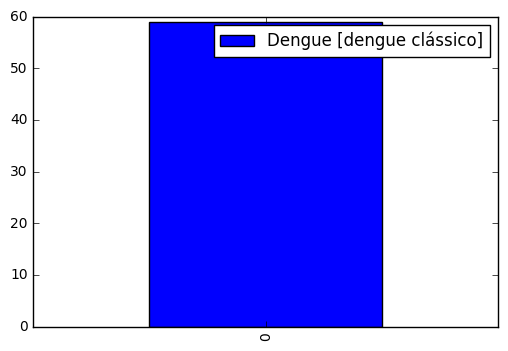

In [20]:
disease_names = df_cid10['nome'].values.tolist()

df_disease = pd.DataFrame({
    k: np.random.randint(1, 100, 1) for k in disease_names
})

display(df_disease)
df_disease.plot(kind='bar')
plt.show()

### Creating of a chart of age distribution with randomic data

,0-4,10-19,20-29,30-39,40-49,5-9,50-59,60+
0,62,67,82,8,25,83,2,37


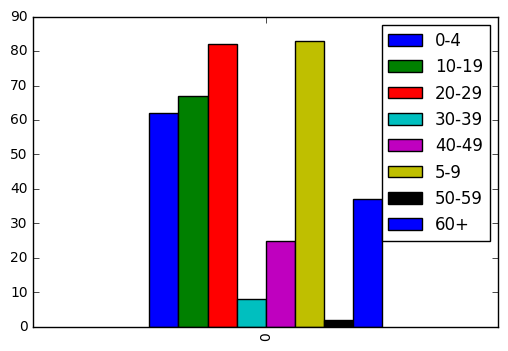

In [21]:
ages_range = [
    '0-4', '5-9', '10-19', '20-29', 
    '30-39', '40-49', '50-59', '60+'
]

df_age = pd.DataFrame({
    age: np.random.randint(1, 100, 1) for age in ages_range
})

display(df_age)
df_age.plot(kind='bar')
plt.show()

### Creating of a chart of gender distribution with randomic data

,female,male
0,72,17


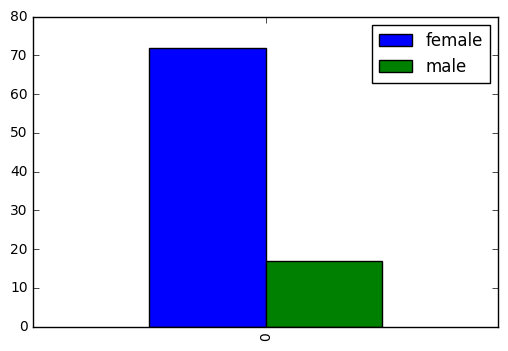

In [22]:
gender_range = ['female', 'male']

df_gender = pd.DataFrame({
    gender: np.random.randint(1, 100, 1) for gender in gender_range
})

display(df_gender)
df_gender.plot(kind='bar')
plt.show()

### Creating of a chart of date distribution with randomic data

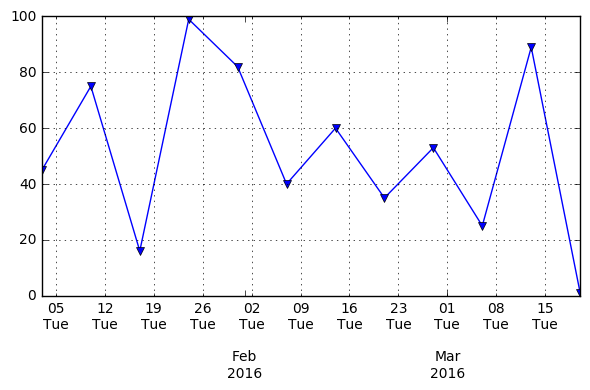

,0
2016-01-03,45
2016-01-10,75
2016-01-17,16
2016-01-24,99
2016-01-31,82


In [23]:
date_range = pd.date_range('1/1/2016', periods=12, freq='w')

df_date = pd.DataFrame({
    date: np.random.randint(1, 100, 1) for date in date_range
}).T

df_date.rename(columns={0: 'cases'})

fig, ax = plt.subplots()
ax.plot_date(date_range.to_pydatetime(), df_date, 'v-')
ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(byweekday=(1), interval=1))
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('\n\n\n%b\n%Y'))

plt.tight_layout()
plt.show()

display(df_date.head())